In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from scipy.optimize import minimize
from scipy.stats import norm

import electricPotentialEnergy as pe

### Initialize the system

Initial Energy: 586.8996218122215


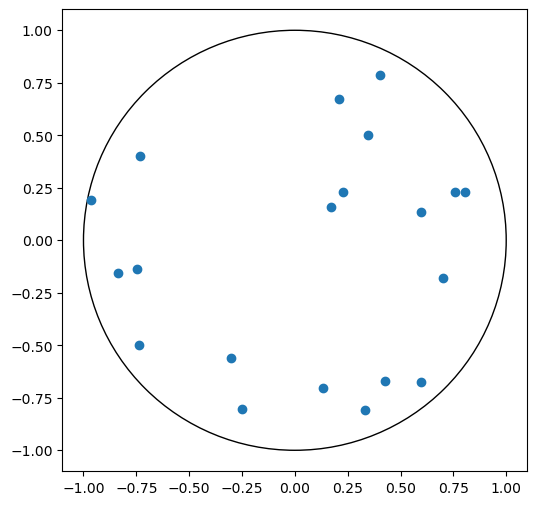

In [24]:
system = pe.Coulomb(20, seed=45)

fig, ax = pe.plotState(system.state)
print(f"Initial Energy: {system.stateEnergy()}")

### Run Simulated Annealing

[569.62237809 567.30599025 575.09117247 ... 388.97978622 388.97978622
 388.97978622]
Final Energy: 388.969692254122


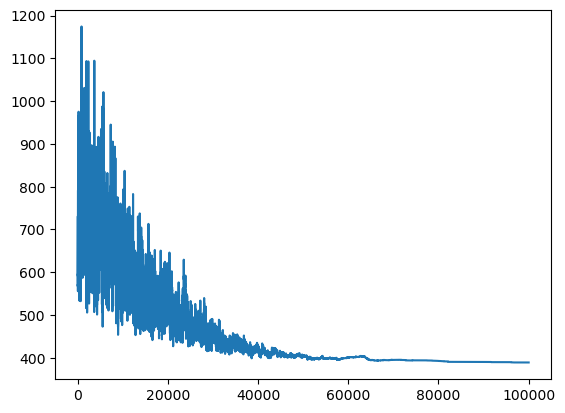

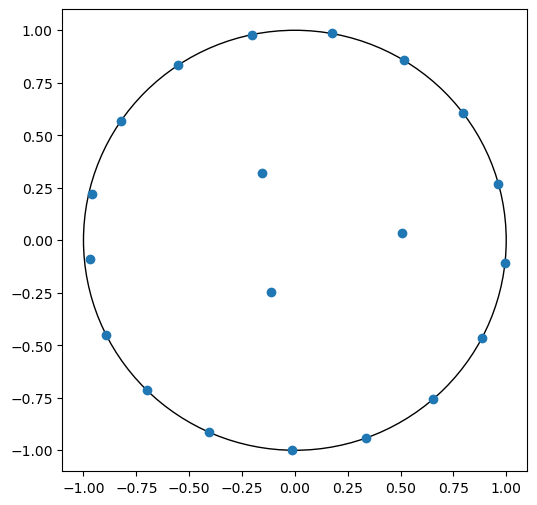

In [25]:
max_iters = 100000
initial_temp = 100
cooling_rate = 0.1
alpha = 0.99
max_step = 2

scheme = pe.geometricCooling(initial_temp, alpha)
optimized_system, energy = pe.simulatedAnnealing(system, 100, max_iters, scheme, max_step)

plt.plot(energy)
print(energy)

fig, ax = pe.plotState(optimized_system.state)
print(f"Final Energy: {optimized_system.stateEnergy()}")
plt.show()

In [ ]:
optimum = minimize(pe.optimize,x0=[0.25, 0.25], method='Powell', bounds=[[0.1,1], [0.1,1]], options={'disp':True})

In [ ]:
print(optimum)

### Load simulation results

In [ ]:
filename = "test"

saved_states = np.load(f"{filename}_states.npy")
saved_energies = np.load(f"{filename}_energies.pny")

### Create animation using simulation results

In [ ]:
def update(frame):
    """Update function for the animation."""
    pe.plotState(saved_states[frame], animation=True, ax=ax)
    ax.set_title(f"Frame {frame+1}")

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(fig, update, frames=len(saved_states), interval=200)

ani.save(f"{filename}.mp4", fps=50)

# Markov Chain length experiment

In [26]:
n_particles = [5, 10, 20, 50]
max_iters = 100000
initial_temp = 100
alpha = 0.99
max_step = 2
chain_lengths = [1, 5, 10, 20, 50, 100]  # Chain lengths to experiment with
repetitions = 10

scheme = pe.geometricCooling(initial_temp, alpha)

parent_dir = "markov_chain_experiments"

### Run experiment

In [ ]:
# os.makedirs(parent_dir, exist_ok=True)

# for n in n_particles:  # Loop through different particle sizes
#     print(f"Running simulations for n_particles = {n}...")
    
#     particle_dir = os.path.join(parent_dir, f"n_particles_{n}")
#     os.makedirs(particle_dir, exist_ok=True)

#     for chain_length in chain_lengths:  # Loop through different chain lengths
#         print(f"  Running for chain_length = {chain_length}...")

#         chain_dir = os.path.join(particle_dir, f"chain_length_{chain_length}")
#         os.makedirs(chain_dir, exist_ok=True)

#         for rep in range(repetitions):
#             system = pe.Coulomb(n, seed=None)  # Use a new seed for each repetition

#             save_path = os.path.join(chain_dir, f"rep_{rep}")
#             optimized_system, _ = pe.simulatedAnnealing(system, chain_length, max_iters, scheme, max_step, save_path=save_path)


### Load results

In [27]:
results = {}

for n in n_particles:
    particle_dir = os.path.join(parent_dir, f"n_particles_{n}")
    
    particle_results = {"energies": [], "states": []}

    for chain_length in chain_lengths:
        chain_dir = os.path.join(particle_dir, f"chain_length_{chain_length}")
        
        chain_results = {"energies": [], "states": []}
        
        for rep in range(repetitions):
            states = np.load(os.path.join(chain_dir, f"rep_{rep}_states.npy"))
            energies = np.load(os.path.join(chain_dir, f"rep_{rep}_energies.npy"))
            
            chain_results["states"].append(states)
            chain_results["energies"].append(energies)
        
        particle_results[chain_length] = chain_results

    results[n] = particle_results

    print(f"Loaded results for n_particles = {n}")


Loaded results for n_particles = 5
Loaded results for n_particles = 10
Loaded results for n_particles = 20
Loaded results for n_particles = 50


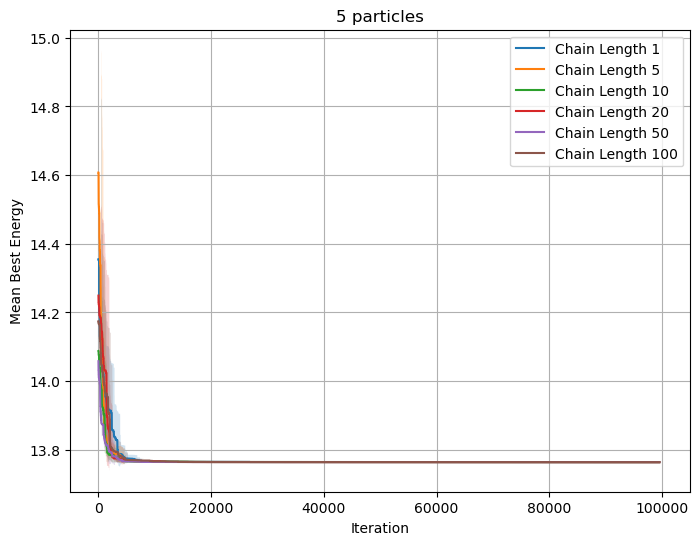

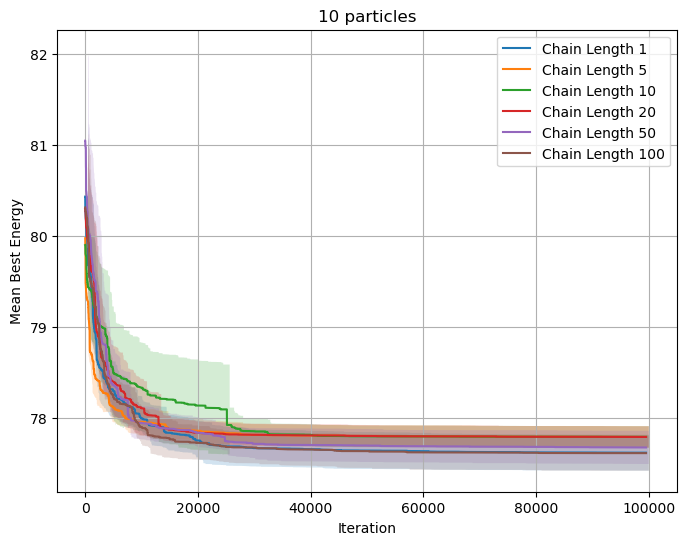

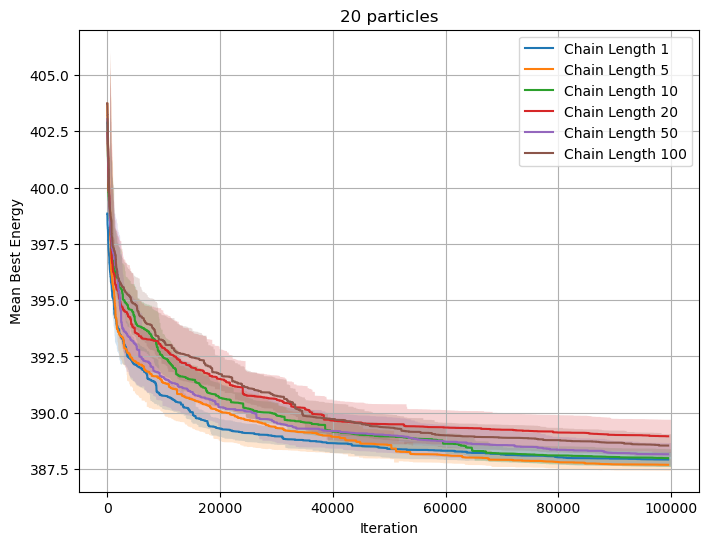

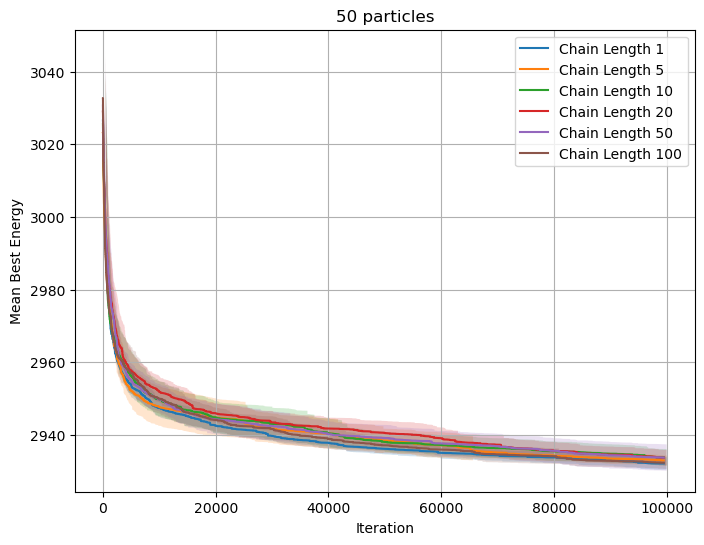

In [28]:
mean_best_energies = {}
confidence_intervals = {}

for n in n_particles:
    for chain_length in chain_lengths:
        running_best_energies = []

        energies = results[n][chain_length]['energies']

        for rep in range(repetitions):
            running_best_energies.append(np.minimum.accumulate(energies[rep]))

        running_best_energies = np.array(running_best_energies)
        mean_running_best_energy = np.mean(running_best_energies, axis=0)
        sem_running_best_energy = np.std(running_best_energies, axis=0, ddof=1) / np.sqrt(repetitions)
        
        z_score = norm.ppf(0.975)
        ci = z_score * sem_running_best_energy

        mean_best_energies[chain_length] = mean_running_best_energy
        confidence_intervals[chain_length] = ci

    plt.figure(figsize=(8, 6))

    for chain_length in chain_lengths:
        mean_best_energy = mean_best_energies[chain_length]
        ci = confidence_intervals[chain_length]
        iterations = range(len(mean_best_energy))

        plt.plot(mean_best_energy[500:-1], label=f"Chain Length {chain_length}")
        plt.fill_between(iterations[500:-1], mean_best_energy[500:-1] - ci[500:-1], mean_best_energy[500:-1] + ci[500:-1], alpha=0.2)
        plt.title(f"{n} particles")

    plt.xlabel("Iteration")
    plt.ylabel("Mean Best Energy")
    plt.legend()
    plt.grid(True)
    plt.show()
